In [5]:
import pandas as pd
import numpy as np
import os
import kagglehub
from collections import namedtuple
import swifter

from pyproj import Transformer
from shapely import union_all
from shapely.ops import transform
import geopandas as gpd

# Load Wine Reviews

In [6]:
fname = "winemag-data-130k-v2.csv"
path = kagglehub.dataset_download("christopheiv/winemagdata130k")
reviews = pd.read_csv(os.path.join(path, fname), index_col=0)
reviews.info()
location_cols=['winery', 'country', 'province', 'region_1', 'region_2']
reviews[location_cols]

<class 'pandas.core.frame.DataFrame'>
Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


,winery,country,province,region_1,region_2
0,Nicosia,Italy,Sicily & Sardinia,Etna,NaN
1,Quinta dos Avidagos,Portugal,Douro,NaN,NaN
2,Rainstorm,US,Oregon,Willamette Valley,Willamette Valley
3,St. Julian,US,Michigan,Lake Michigan Shore,NaN
4,Sweet Cheeks,US,Oregon,Willamette Valley,Willamette Valley
...,...,...,...,...,...
129966,Dr. H. Thanisch (Erben Müller-Burggraef),Germany,Mosel,NaN,NaN
129967,Citation,US,Oregon,Oregon,Oregon Other
129968,Domaine Gresser,France,Alsace,Alsace,NaN
129969,Domaine Marcel Deiss,France,Alsace,Alsace,NaN


**Extract Countries with Wine Reviews**

In [7]:
country_names = np.unique(reviews.loc[reviews.country.notna(), 'country'])
print('there are reviews from', len(country_names), 'distinct countries')
country_names

there are reviews from 43 distinct countries


array(['Argentina', 'Armenia', 'Australia', 'Austria',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Chile',
       'China', 'Croatia', 'Cyprus', 'Czech Republic', 'Egypt', 'England',
       'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India',
       'Israel', 'Italy', 'Lebanon', 'Luxembourg', 'Macedonia', 'Mexico',
       'Moldova', 'Morocco', 'New Zealand', 'Peru', 'Portugal', 'Romania',
       'Serbia', 'Slovakia', 'Slovenia', 'South Africa', 'Spain',
       'Switzerland', 'Turkey', 'US', 'Ukraine', 'Uruguay'], dtype=object)

# Countries

### Data Source
- [Natural Earth](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-details/)

**Load Outlines of Countries In Lat Lon Cartesian Coordinates**

In [8]:
# load the high resolution country shapes
file = 'data/ne_10m_admin_0_map_units/'
columns = [
  # 'featurecla', 'scalerank', 'LABELRANK',
  'SOVEREIGNT', #'SOV_A3',
  # 'ADM0_DIF', 
  'LEVEL', 'TYPE',
  # 'TLC',
  'ADMIN', #'ADM0_A3', 'GEOU_DIF',
  'GEOUNIT',
  # 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF',
  'NAME', 'NAME_LONG',
  # 'BRK_A3', 'BRK_NAME', 'BRK_GROUP',
  'ABBREV',
  # 'POSTAL',
  # 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0',
  # 'NOTE_BRK',
  'NAME_SORT', 'NAME_ALT',
  # 'MAPCOLOR7', 'MAPCOLOR8',
  # 'MAPCOLOR9', 'MAPCOLOR13',
  'POP_EST',
  # 'POP_RANK',
  'POP_YEAR',
  'GDP_MD',
  'GDP_YEAR',
  'ECONOMY', 'INCOME_GRP',
  # 'FIPS_10',
  'ISO_A2',
  'ISO_A2_EH', #'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3',
  # 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 
  'ADM0_ISO',
  # 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU',
  # 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN',
  # 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB',
  # 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA',
  # 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR',
  # 'ADM0_A3_JP', 'ADM0_A3_KO', 'ADM0_A3_VN', 'ADM0_A3_TR',
  # 'ADM0_A3_ID', 'ADM0_A3_PL', 'ADM0_A3_GR', 'ADM0_A3_IT',
  # 'ADM0_A3_NL', 'ADM0_A3_SE', 'ADM0_A3_BD', 'ADM0_A3_UA',
  # 'ADM0_A3_UN', 'ADM0_A3_WB',
  'CONTINENT', #'REGION_UN', 'SUBREGION',
  # 'REGION_WB', 'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 
  # 'TINY',
  # 'HOMEPART', 'MIN_ZOOM', 'MIN_LABEL', 'MAX_LABEL', 'LABEL_X',
  # 'LABEL_Y', 'NE_ID', 'WIKIDATAID', 'NAME_AR', 'NAME_BN', 'NAME_DE',
  'NAME_EN', #'NAME_ES', 'NAME_FA', 'NAME_FR', 'NAME_EL', 'NAME_HE',
  # 'NAME_HI', 'NAME_HU', 'NAME_ID', 'NAME_IT', 'NAME_JA', 'NAME_KO',
  # 'NAME_NL', 'NAME_PL', 'NAME_PT', 'NAME_RU', 'NAME_SV', 'NAME_TR',
  # 'NAME_UK', 'NAME_UR', 'NAME_VI', 'NAME_ZH', 'NAME_ZHT',
  # 'FCLASS_ISO', 'TLC_DIFF', 'FCLASS_TLC', 'FCLASS_US', 'FCLASS_FR',
  # 'FCLASS_RU', 'FCLASS_ES', 'FCLASS_CN', 'FCLASS_TW', 'FCLASS_IN',
  # 'FCLASS_NP', 'FCLASS_PK', 'FCLASS_DE', 'FCLASS_GB', 'FCLASS_BR',
  # 'FCLASS_IL', 'FCLASS_PS', 'FCLASS_SA', 'FCLASS_EG', 'FCLASS_MA',
  # 'FCLASS_PT', 'FCLASS_AR', 'FCLASS_JP', 'FCLASS_KO', 'FCLASS_VN',
  # 'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
  # 'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 
  'geometry'
]
world = gpd.read_file(file, columns=columns).rename(columns={'ISO_A2_EH': 'code'})
world[['GEOUNIT', 'NAME','code', 'ADM0_ISO', 'ISO_A2']]

,GEOUNIT,NAME,code,ADM0_ISO,ISO_A2
0,Indonesia,Indonesia,ID,IDN,ID
1,Malaysia,Malaysia,MY,MYS,MY
2,Chile,Chile,CL,CHL,CL
3,Bolivia,Bolivia,BO,BOL,BO
4,Peru,Peru,PE,PER,PE
...,...,...,...,...,...
293,Palmyra Atoll,Palmyra Atoll,US,UMI,-99
294,Kingman Reef,Kingman Reef,US,UMI,-99
295,Bajo Nuevo Bank (Petrel Is.),Bajo Nuevo Bank,-99,-99,-99
296,Serranilla Bank,Serranilla Bank,-99,-99,-99


**Country Codes**

In [9]:
world[world.GEOUNIT == 'Serbia'][['GEOUNIT', 'NAME','code', 'ADM0_ISO', 'ISO_A2']]

,GEOUNIT,NAME,code,ADM0_ISO,ISO_A2
137,Serbia,Serbia,RS,SRB,-99


**Country Names**

In [10]:
name_columns = list(filter(lambda n: 'NAME' in n, world.columns)) + ['SOVEREIGNT', 'ADMIN','ABBREV','GEOUNIT']
countries = world[name_columns]
countries

,NAME,NAME_ALT,NAME_EN,NAME_LONG,NAME_SORT,SOVEREIGNT,ADMIN,ABBREV,GEOUNIT
0,Indonesia,None,Indonesia,Indonesia,Indonesia,Indonesia,Indonesia,Indo.,Indonesia
1,Malaysia,None,Malaysia,Malaysia,Malaysia,Malaysia,Malaysia,Malay.,Malaysia
2,Chile,None,Chile,Chile,Chile,Chile,Chile,Chile,Chile
3,Bolivia,None,Bolivia,Bolivia,Bolivia,Bolivia,Bolivia,Bolivia,Bolivia
4,Peru,None,Peru,Peru,Peru,Peru,Peru,Peru,Peru
...,...,...,...,...,...,...,...,...,...
293,Palmyra Atoll,None,Palmyra Atoll,Palmyra Atoll,Palmyra Atoll,United States of America,United States Minor Outlying Islands,Palm. At.,Palmyra Atoll
294,Kingman Reef,None,Kingman Reef,Kingman Reef,Kingman Reef,United States of America,United States Minor Outlying Islands,King. Rf.,Kingman Reef
295,Bajo Nuevo Bank,None,Bajo Nuevo Bank,Bajo Nuevo Bank (Petrel Islands),Bajo Nuevo Bank (Petrel Is.),Bajo Nuevo Bank (Petrel Is.),Bajo Nuevo Bank (Petrel Is.),None,Bajo Nuevo Bank (Petrel Is.)
296,Serranilla Bank,None,Serranilla Bank,Serranilla Bank,Serranilla Bank,Serranilla Bank,Serranilla Bank,S.B.,Serranilla Bank


**Countries with Multiple Geographic Units**

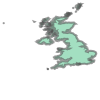

In [11]:
gb = union_all(
  [
    world[world.GEOUNIT == 'England'].geometry.values[0],
    world[world.GEOUNIT == 'Wales'].geometry.values[0],
    world[world.GEOUNIT == 'Scotland'].geometry.values[0],
    world[world.GEOUNIT == 'Northern Ireland'].geometry.values[0],
  ]
)
gb

**Mercator Projection**

In [12]:
# configure coordinate system transformer - from lat lon to m
transformer = Transformer.from_crs(4326, 3857, always_xy=True)

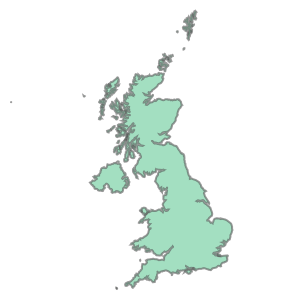

In [13]:
transform(func=transformer.transform, geom=gb)

### Define search boundaries for countries

In [14]:
def fix_name(country):
  overrides = {
    'US': 'United States of America',
    'Macedonia': 'North Macedonia',
    'Czech Republic': 'Czechia'
  }
  return overrides[country] if country in overrides else country

BOUNDARY = namedtuple('BOUNDARY', ['GEOUNIT', 'ADMIN', 'code', 'geometry', 'area'], defaults=[None]*5)

to_tuple = lambda row: BOUNDARY(
  row.GEOUNIT.values[0],
  row.ADMIN.values[0],
  row.code.values[0],
  row.geometry.values[0],
  transform(func=transformer.transform, geom=row.geometry.values[0]).area,
)

**Assign Search Boundaries for Countries in the Wine Review Dataset**

In [15]:
# use a dict for fast performance, small data set.
countries = {
  country: to_tuple(world[world.GEOUNIT == fix_name(country)])
  for country in country_names
}

countries

{'Argentina': BOUNDARY(GEOUNIT='Argentina', ADMIN='Argentina', code='AR', geometry=<MULTIPOLYGON (((-67.194 -22.822, -67.143 -22.743, -67.113 -22.71, -67.038 -...>, area=4316299064470.5015),
 'Armenia': BOUNDARY(GEOUNIT='Armenia', ADMIN='Armenia', code='AM', geometry=<MULTIPOLYGON (((45.002 41.29, 45.039 41.231, 45.029 41.21, 45.035 41.198, 4...>, area=50915361517.49648),
 'Australia': BOUNDARY(GEOUNIT='Australia', ADMIN='Australia', code='AU', geometry=<MULTIPOLYGON (((131.536 -31.606, 131.346 -31.531, 131.178 -31.478, 131.135 ...>, area=9657073647913.473),
 'Austria': BOUNDARY(GEOUNIT='Austria', ADMIN='Austria', code='AT', geometry=<POLYGON ((16.945 48.604, 16.954 48.557, 16.949 48.545, 16.947 48.54, 16.93 ...>, area=184562245985.02414),
 'Bosnia and Herzegovina': BOUNDARY(GEOUNIT='Bosnia and Herzegovina', ADMIN='Bosnia and Herzegovina', code='BA', geometry=<MULTIPOLYGON (((17.653 42.891, 17.653 42.891, 17.556 42.935, 17.574 42.934,...>, area=55895958457.45568),
 'Brazil': BOUNDARY(G

<Axes: >

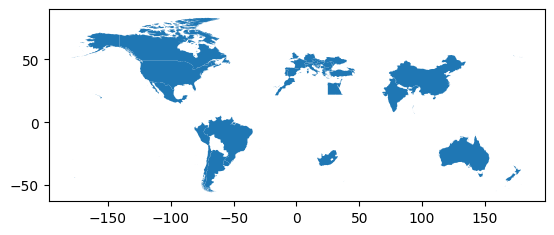

In [16]:
# Before
gpd.GeoSeries(list(map(lambda country: country.geometry, countries.values()))).plot()

**Determine whether any countries need to be adjusted**

In [17]:
to_fix = list(filter(lambda country: countries[country].GEOUNIT != countries[country].ADMIN, countries))
to_fix

['England', 'Serbia']

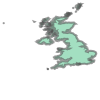

In [18]:
union_all(world[world.ADMIN == 'United Kingdom'].geometry.values)

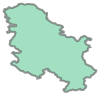

In [19]:
union_all(world[world.ADMIN == 'Republic of Serbia'].geometry.values)

**Fix the regions with issues**

In [20]:
# fix the regions
for country in to_fix:
  geometry = union_all(world[world.ADMIN == countries[country].ADMIN].geometry.values)
  countries[country] = BOUNDARY(
    countries[country].GEOUNIT,
    countries[country].ADMIN,
    countries[country].code,
    geometry,
    transform(func=transformer.transform, geom=geometry)
  )

<Axes: >

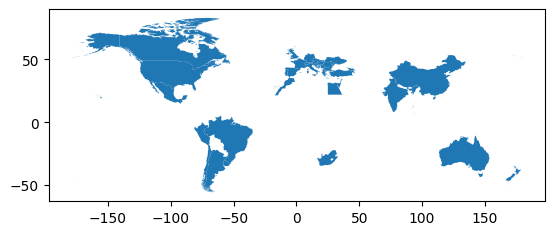

In [21]:
# After
gpd.GeoSeries(list(map(lambda country: country.geometry, countries.values()))).plot()

### Augment the reviews with the corresponding search boundaries

In [22]:
reviews.loc[reviews.country.notna(), 'geometry'] = reviews[reviews.country.notna()].country.swifter.apply(lambda country: countries[country].geometry)
reviews.loc[reviews.country.notna(), 'code'] = reviews[reviews.country.notna()].country.swifter.apply(lambda country: countries[country].code.lower())
reviews.loc[reviews.country.notna(), 'area'] = reviews[reviews.country.notna()].country.swifter.apply(lambda country: countries[country].area)
greviews = gpd.GeoDataFrame(reviews, geometry='geometry')
greviews.info()
greviews

Pandas Apply:   0%|          | 0/129908 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129908 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/129908 [00:00<?, ?it/s]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 129971 entries, 0 to 129970
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   country                129908 non-null  object  
 1   description            129971 non-null  object  
 2   designation            92506 non-null   object  
 3   points                 129971 non-null  int64   
 4   price                  120975 non-null  float64 
 5   province               129908 non-null  object  
 6   region_1               108724 non-null  object  
 7   region_2               50511 non-null   object  
 8   taster_name            103727 non-null  object  
 9   taster_twitter_handle  98758 non-null   object  
 10  title                  129971 non-null  object  
 11  variety                129970 non-null  object  
 12  winery                 129971 non-null  object  
 13  geometry               129908 non-null  geometry
 14  code             

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,geometry,code,area
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"MULTIPOLYGON (((7.02208 45.92526, 7.06694 45.8...",it,561749878530.692749
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"MULTIPOLYGON (((-7.10486 38.82719, -7.15101 38...",pt,148854686676.751465
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532...",us,21721578635832.066406
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532...",us,21721578635832.066406
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532...",us,21721578635832.066406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),"MULTIPOLYGON (((13.81572 48.76643, 13.78586 48...",de,908447061046.873047
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,"MULTIPOLYGON (((-122.75302 48.99251, -122.6532...",us,21721578635832.066406
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,"MULTIPOLYGON (((2.5218 51.08754, 2.53703 51.06...",fr,1161500798825.095947
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,"MULTIPOLYGON (((2.5218 51.08754, 2.53703 51.06...",fr,1161500798825.095947
